In [ ]:
! pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 54.2 MB/s eta 0:00:00


In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

def read_h5_images(h5_file):
    image_arrays = []
    with h5py.File(h5_file, 'r') as hf:
        keys = list(hf.keys())
        num_images = min(200, len(keys))

        for i in range(num_images):
            image_data = hf[keys[i]][()]
            image_arrays.append(image_data)

    return image_arrays

def display_images(image_arrays , number):
    num_images = len(image_arrays)
    num_rows = int(np.ceil(num_images / 10))
    fig, axes = plt.subplots(num_rows, 10, figsize=(15, num_rows * 1.5))



    for i in range(num_images):
        if num_rows > 1:
            ax = axes[i // 10, i % 10]
        else:
            ax = axes[i % 10]
        fig_1, ax_1 = plt.subplots(figsize=(image_arrays[i].shape[1]/100, image_arrays[i].shape[0]/100))
        ax_1.imshow(image_arrays[i], cmap='gray')
        ax_1.axis('off')

        if ( i < 160 ):
          plt.savefig("quanvolution_images/train/"+str(number)+"/"+str(i)+".jpg")
        else:
          plt.savefig("quanvolution_images/val/"+str(number)+"/"+str(i)+".jpg")


        ax.imshow(image_arrays[i], cmap='gray')
        ax.axis('off')

syndrome_images = read_h5_images('syndrome_data_200_32.h5')
non_syndrome_images = read_h5_images('non_syndrome_data_200_32.h5')

syndrome_images = np.array(syndrome_images) / 255
non_syndrome_images = np.array(non_syndrome_images) / 255

syndrome_labels = np.ones(len(syndrome_images))
non_syndrome_labels = np.zeros(len(non_syndrome_images))

print('Syndrome Images')
display_images(syndrome_images , 0 )
print('Non Syndrome Images')
display_images(non_syndrome_images , 1 )

In [ ]:
!rm -r quanvolution_images/val/.ipynb_checkpoints/

In [ ]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import pennylane as qml
from pennylane import numpy as np
torch.manual_seed(42)
np.random.seed(42)
import matplotlib.pyplot as plt


In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 8             # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "quanvolution_images"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}


# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

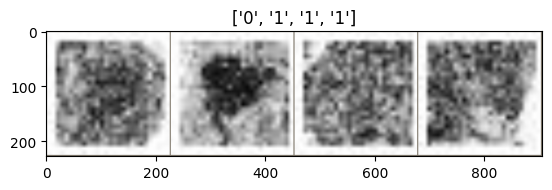

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [ ]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
"""
  Variational quantum circuit.
"""
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):


    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    H_layer(n_qubits)

    RY_layer(q_input_features)

    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        # Reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        return self.post_net(q_out)

In [ ]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False


model_hybrid.fc = DressedQuantumNet()

model_hybrid = model_hybrid.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):

     # Lists to store evaluation metrics and loss curves for each split
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    all_train_avg_loss_curves = []
    all_valid_avg_loss_curves = []
    all_avg_accuracies_curves = []
    min_losses = []
    cms = []

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            if ( phase == "train" ):
              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects / dataset_sizes[phase]
              all_train_avg_loss_curves.append(epoch_loss)
            else:
              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = running_corrects / dataset_sizes[phase]
              all_valid_avg_loss_curves.append(epoch_loss)
              all_avg_accuracies_curves.append(epoch_acc)
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return  all_train_avg_loss_curves ,all_valid_avg_loss_curves , all_avg_accuracies_curves

In [ ]:
def plot_multiple_splits_loss_curve(avg_train_loss_curve, avg_valid_loss_curve, title):

    # Set up the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot loss curves for each model
    plt.plot(avg_train_loss_curve, label='Average Training Loss', marker='o', color='mediumblue', linestyle='-')
    plt.plot(avg_valid_loss_curve, label='Average Validation Loss', marker='o', color='crimson', linestyle='-')

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title(f'{title} - Validation Loss Curves')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

def plot_multiple_splits_accuracy_curve(avg_accuracy_curve, title):

    # Set up the figure and axis
    plt.figure(figsize=(10, 6))

    # Plot loss curves for each model
    plt.plot(avg_accuracy_curve, label='Average Validation Accuracy', marker='o', color='mediumturquoise', linestyle='-')

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title} - Validation Accuracy Curve')

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

In [ ]:
all_train_avg_loss_curves ,all_valid_avg_loss_curves , all_avg_accuracies_curves = model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

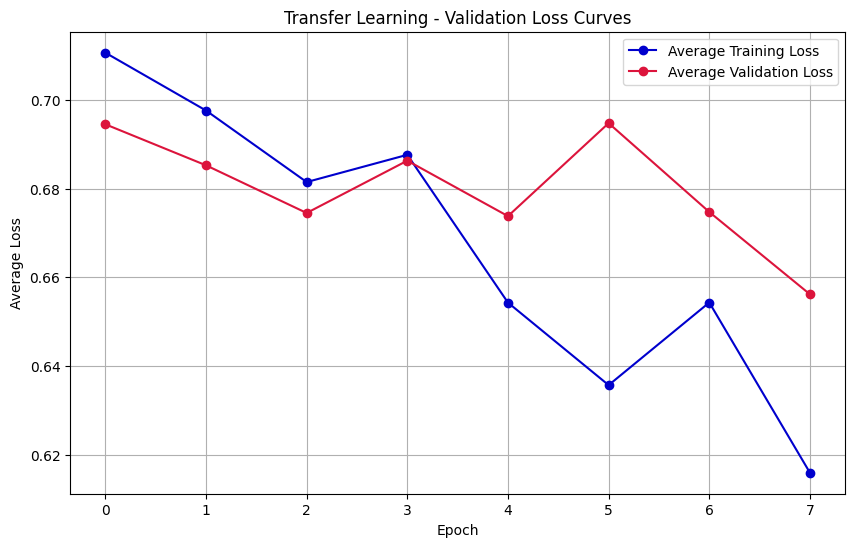

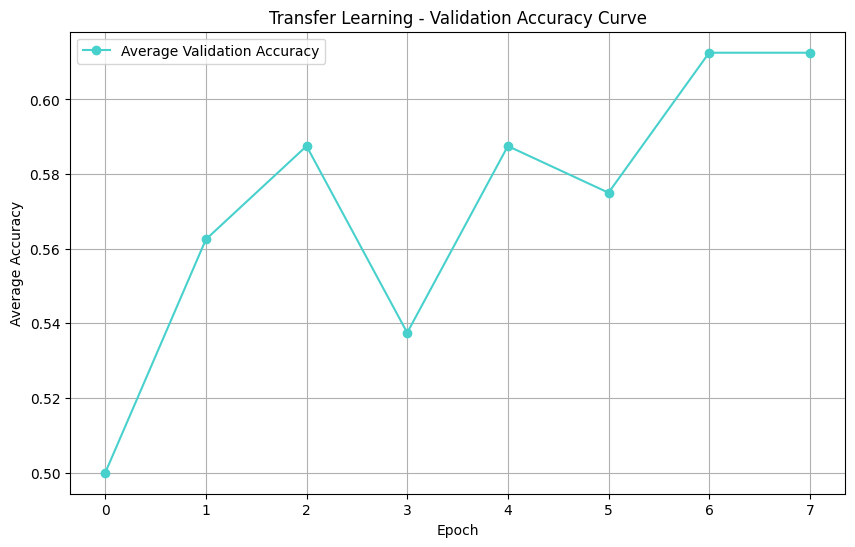

In [ ]:
plot_multiple_splits_loss_curve(all_train_avg_loss_curves, all_valid_avg_loss_curves, title='Transfer Learning')

plot_multiple_splits_accuracy_curve(all_avg_accuracies_curves, title='Transfer Learning')